In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from IPython.display import Image, clear_output

tf.__version__

'2.6.0'

In [40]:
# load extracted dataset from MIT-BIH dataset Arrhythmia database (only N, A, V, R, L)
#data = tf.keras.datasets.fashion_mnist

X_train_full = np.load('data/X.npy')
y_train_full = np.load('data/y.npy')
X_test = np.load('data/X_val.npy')
y_test = np.load('data/y_val.npy')

# # lors de la création des test et train set, j'ai mis après chaque battement les intervalles avec le pic précédent et le pic suivant
# # après plusieurs tentatives d'entraînements de mlp, j'ai décidé de les enlever, puisqu'ils pertubaient l'apprentissage 
# # -> on s'éloigne du papier "M. Wess, P. D. Sai Manoj and A. Jantsch, Neural network based ECG anomaly detection on FPGA and trade-off analysis, 2017"
X_train_full = np.array(X_train_full[:,:-2])
X_test = np.array(X_test[:,:-2])

print("X_train_full shape from MIT-BIH:",X_train_full.shape)
print("X_text shape from MIT-BIH:",X_test.shape)

# apply pca
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_train_full = pca.fit_transform(X_train_full) # on applique la pca sur le train_set, réduction du nombre de composantes de chaques vecteur à 10
X_test = pca.transform(X_test) # on applique la même pca (.transform(), pas fit_transform()) sur le test_set

print("PCA Explained variance ratio:", pca.explained_variance_ratio_) # affichage de l'explained variance ratio, on voit le détail de l'explication de la variance pour chacune des 10 composantes
print("Sum of PCA explained variance ratio ", np.sum(pca.explained_variance_ratio_)) # la somme fait 0.987, ie 98.7 % de la variance est expliquée par les 10 coordonnées après la pca

#(X_train_full, y_train_full), (X_test, y_test) = data.load_data()
print("X_train_full shape after PCA:",X_train_full.shape)
print("X_test shape after PCA:", X_test.shape)

# save data for reuse...
np.save('X_train_full.npy', X_train_full)
np.save('X_test.npy', X_test)
np.save('y_train_full.npy', y_train_full)
np.save('y_test_arrythmia_classes.npy', y_test)



X_train_full shape from MIT-BIH: (5000, 181)
X_text shape from MIT-BIH: (5000, 181)
PCA Explained variance ratio: [0.48252245 0.31996482 0.08224719 0.04314785 0.02251032 0.01319468
 0.00924953 0.00540838 0.00464092 0.00411689]
Sum of PCA explained variance ratio  0.987003039861972
X_train_full shape after PCA: (5000, 10)
X_test shape after PCA: (5000, 10)


In [41]:
# transform y_train class characters in number !
class_names = {'A':'Atrial premature contraction (A)','V':'Premature venticular contraction (V)','N':'Normal beat (N)','L':'Left bundle branch block (L)','R':'Right bundle branch block beat (R)'}
mapping_to_numbers = {}
y_train_full_number = np.zeros((len(y_train_full)))
for i, raw_label in enumerate(y_train_full):
    if raw_label not in mapping_to_numbers:
        mapping_to_numbers[raw_label] = len(mapping_to_numbers)
    y_train_full_number[i] = mapping_to_numbers[raw_label]
# [0. 1. 2. 3. 1. 2.]
print("Class names for numbers:", mapping_to_numbers)
# could be {'A': 0, 'V': 1, 'N': 2, 'L': 3, 'R': 4}
y_test_number = np.zeros((len(y_test)))
for i in range(len(y_test)):
    y_test_number[i] = mapping_to_numbers[y_test[i]]

print("y_train shape:", y_train_full.shape)
print("y_train shape with number:", y_train_full_number.shape)

np.save('y_test.npy', y_test_number)

Class names for numbers: {'A': 0, 'V': 1, 'N': 2, 'L': 3, 'R': 4}
y_train shape: (5000,)
y_train shape with number: (5000,)


In [46]:
# TBD: Normalize data ???
# X_train_full = X_train_full / 255.0
# X_test  = X_test / 255.0
        
# Split training dataset in two dataset: the validation and training sets
X_valid, X_train = X_train_full[:2500], X_train_full[2500:]
y_valid, y_train = y_train_full_number[:2500], y_train_full_number[2500:]

# Specify the model's architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = [10,1]),
    tf.keras.layers.Dense(5, activation='relu'), # relu activation function 
    # tf.keras.layers.Dense(5, activation='tanh'), # tanh activation function which is the same of the publication
    tf.keras.layers.Dense(5, activation='softmax'),
])

# Specify the loss function, optimizer, metrics
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Train the model
history = model.fit(
    X_train, y_train, epochs=10,
    validation_data = (X_valid, y_valid),
    verbose=0
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 30        
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


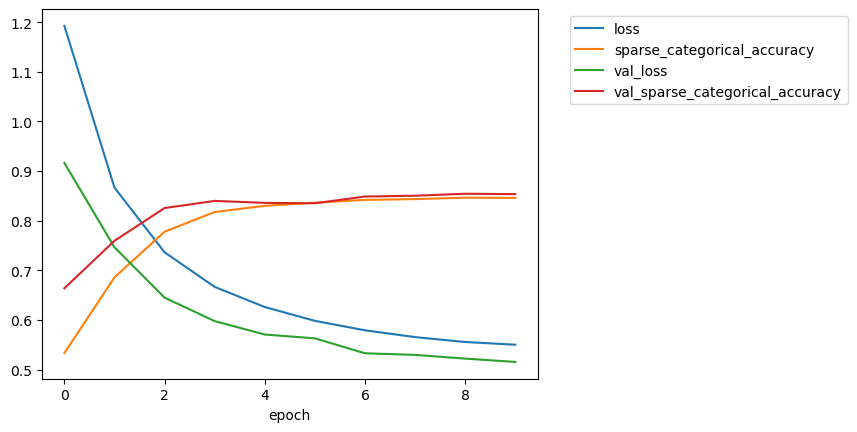

In [47]:
# display results
pd.DataFrame(history.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [48]:
# Precision du modèle
loss, acc = model.evaluate(X_test, y_test_number)

157/157 [==============================] - 0s 466us/step - loss: 0.5323 - sparse_categorical_accuracy: 0.8476


In [45]:
# save model 
model.save("mlp.h5")
    